In [1]:
!pip install torch trl sentencepiece safetensors
!pip install -U bitsandbytes
!pip install -U transformers datasets peft accelerate
!pip install datasets
!pip install peft
!pip install --upgrade peft
!pip install -U datasets
!pip install --upgrade transformers
!pip install wandb





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.4/366.4 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvj

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import load_dataset
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import wandb
wandb.login(key="")

2025-06-19 06:18:24.721782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750313905.076652      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750313905.174185      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.

True

In [5]:
import torch
import torch.nn as nn
from transformers import (
    DistilBertTokenizer, DistilBertConfig, DistilBertModel,
    PreTrainedModel, Trainer, TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import load_dataset
import numpy as np
import json

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Load and split Pandora Big5 dataset (first 20,000 samples)
ds = load_dataset("jingjietan/pandora-big5", split="train[:20000]")
ds = ds.train_test_split(test_size=0.2, seed=42)
train_ds = ds["train"]
val_ds = ds["test"]

# Custom classifier using DistilBERT and a linear head for 5 personality traits
class DistilBertBig5Classifier(PreTrainedModel):
    config_class = DistilBertConfig
    def __init__(self, config):
        super().__init__(config)
        self.distilbert = DistilBertModel(config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, 5)  # 5 output classes: OCEAN

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        kwargs.pop("num_items_in_batch", None)  # Remove unwanted arg from LoRA
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token representation
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()  # Multi-label classification
            loss = loss_fct(logits, labels)
        return SequenceClassifierOutput(loss=loss, logits=logits)

# Convert dataset examples into tokenized inputs with binary labels for each trait
def preprocess(example):
    inputs = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    labels = torch.tensor(
        [int(example[trait] >= 50) for trait in ["O", "C", "E", "A", "N"]],
        dtype=torch.float
    )
    inputs["labels"] = labels
    return inputs

# Tokenize and preprocess training and validation sets
train_ds = train_ds.map(preprocess, remove_columns=train_ds.column_names)
val_ds = val_ds.map(preprocess, remove_columns=val_ds.column_names)
train_ds.set_format(type="torch")
val_ds.set_format(type="torch")

# Define hyperparameters
learning_rates = [1e-3, 3e-3, 5e-3, 7e-3, 1e-2]
epochs = [7]
batch_size = 8

results = {}

# Loop over each combination of epoch and learning rate
for epoch in epochs:
    for lr in learning_rates:
        print(f"Training for {epoch} epochs with lr={lr}")

        # Initialize model with DistilBERT config
        config = DistilBertConfig.from_pretrained(model_name)
        model = DistilBertBig5Classifier(config).to(device)

        # Prepare model for LoRA fine-tuning
        model = prepare_model_for_kbit_training(model)
        lora_config = LoraConfig(
            r=8,
            lora_alpha=16,
            target_modules=["q_lin", "v_lin"],
            lora_dropout=0.1,
            bias="none",
            task_type="SEQ_CLS"
        )
        model = get_peft_model(model, lora_config)

        # Define training arguments
        training_args = TrainingArguments(
            output_dir=f"./lora-distilbert-big5-ep{epoch}-lr{lr}",
            per_device_train_batch_size=batch_size,
            gradient_accumulation_steps=2,
            num_train_epochs=epoch,
            learning_rate=lr,
            fp16=False,
            logging_steps=100,
            save_strategy="no",
            eval_strategy="no"
        )

        # Train the model using HuggingFace Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_ds,
            tokenizer=tokenizer
        )
        trainer.train()

        # Evaluate on validation set
        model.eval()
        model.to(device)

        y_true, y_pred = [], []

        # Loop over validation examples for manual evaluation
        for batch in val_ds:
            inputs = {k: batch[k].unsqueeze(0).to(device) for k in ["input_ids", "attention_mask"]}
            labels = batch["labels"].unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                preds = (torch.sigmoid(outputs.logits) > 0.5).float().cpu().numpy()
                true = labels.cpu().numpy()
                y_pred.append(preds[0])
                y_true.append(true[0])

        # Compute accuracy metrics
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        trait_names = ["O", "C", "E", "A", "N"]
        accuracy_per_trait = np.mean(y_true == y_pred, axis=0).tolist()
        overall_accuracy = np.mean(y_true == y_pred) * 100

        # Store results
        results[f"epoch={epoch}_lr={lr}"] = {
            "accuracy_per_trait": dict(zip(trait_names, accuracy_per_trait)),
            "overall_accuracy": float(overall_accuracy)
        }

# Save results to JSON file
with open("distilbert_big5_binary_results.json", "w") as f:
    json.dump(results, f, indent=2)


Training for 7 epochs with lr=0.001


/tmp/ipykernel_35/2261551598.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,1.344900
200,1.344300
300,1.344500
400,1.330800
500,1.345100
600,1.320900
700,1.335900
800,1.325300
900,1.331800
1000,1.326300


Training for 7 epochs with lr=0.003


/tmp/ipykernel_35/2261551598.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,1.419500
200,1.407100
300,1.401400
400,1.377300
500,1.381000
600,1.367700
700,1.360700
800,1.373000
900,1.361100
1000,1.351100


Training for 7 epochs with lr=0.005


/tmp/ipykernel_35/2261551598.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,1.522100
200,1.448800
300,1.401200
400,1.398400
500,1.428300
600,1.353700
700,1.381600
800,1.348000
900,1.322800
1000,1.334200


Training for 7 epochs with lr=0.007


/tmp/ipykernel_35/2261551598.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,1.609800
200,1.498400
300,1.437700
400,1.386900
500,1.688400
600,1.344800
700,1.350700
800,1.343600
900,1.342200
1000,1.437200


Training for 7 epochs with lr=0.01


/tmp/ipykernel_35/2261551598.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,1.657100
200,1.563000
300,2.041100
400,1.581500
500,1.438100
600,1.734800
700,1.428900
800,1.363300
900,1.345500
1000,1.340200


In [6]:
import pandas as pd
import json

# Load results from saved JSON file
with open("distilbert_big5_binary_results.json", "r") as f:
    results = json.load(f)

# Create table from results
data = []
for config, metrics in results.items():
    row = {
        "config": config,
        "overall_accuracy": metrics["overall_accuracy"]
    }
    for trait, acc in metrics["accuracy_per_trait"].items():
        row[f"{trait}_accuracy"] = acc
    data.append(row)

# Convert to DataFrame and sort
df = pd.DataFrame(data)
df_sorted = df.sort_values("overall_accuracy", ascending=False)

# Display top rows
print(df_sorted.to_string(index=False))


          config  overall_accuracy  O_accuracy  C_accuracy  E_accuracy  A_accuracy  N_accuracy
epoch=7_lr=0.001            62.730     0.56400     0.72275     0.66150     0.64675     0.54150
epoch=7_lr=0.005            62.625     0.57875     0.72300     0.66425     0.64625     0.51900
epoch=7_lr=0.007            62.445     0.57700     0.72300     0.66400     0.64725     0.51100
 epoch=7_lr=0.01            62.075     0.57900     0.72300     0.66425     0.64600     0.49150
epoch=7_lr=0.003            61.930     0.57825     0.72300     0.66425     0.64625     0.48475


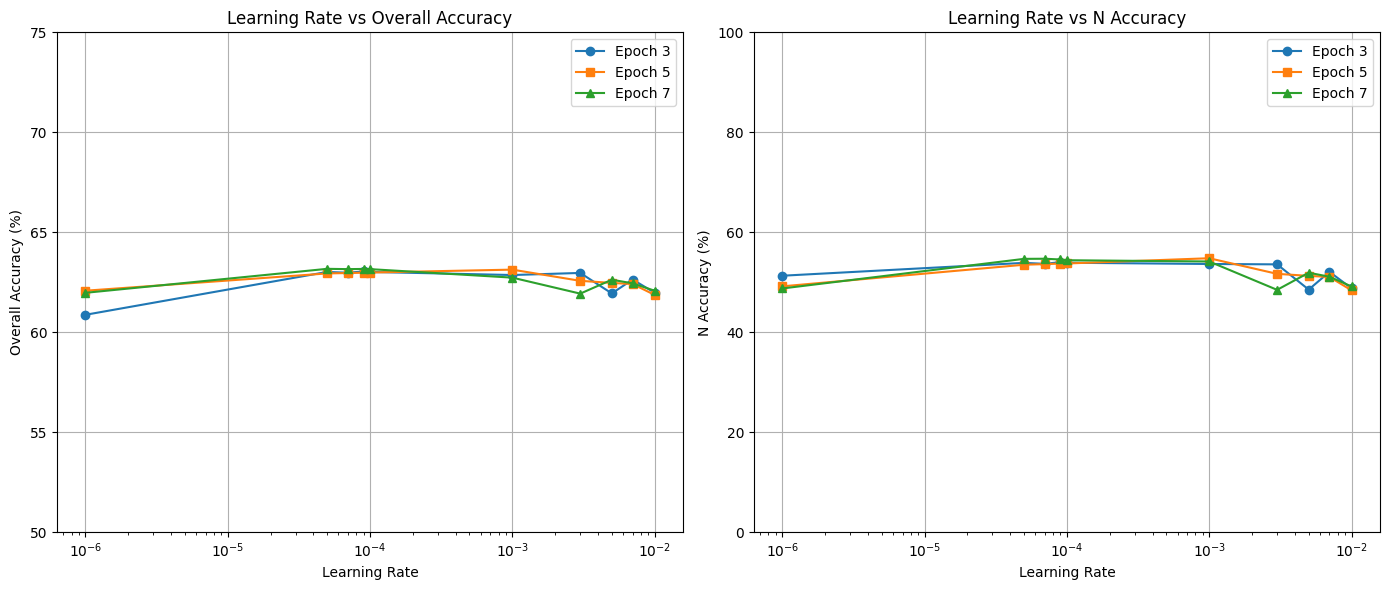

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Sorted common learning rates
common_lrs = [1e-6, 5e-5, 7e-5, 9e-5, 1e-4, 1e-3, 3e-3, 5e-3, 7e-3, 1e-2]

# Updated data from your tables
epoch3 = {
    1e-6: (60.870, 0.51300),
    5e-5: (63.015, 0.53875),
    7e-5: (62.975, 0.53675),
    9e-5: (63.040, 0.54025),
    1e-4: (63.015, 0.53900),
    1e-3: (62.860, 0.53650),
    3e-3: (62.965, 0.53575),
    5e-3: (61.940, 0.48525),
    7e-3: (62.635, 0.52075),
    1e-2: (61.975, 0.48775)
}

epoch5 = {
    1e-6: (62.075, 0.49175),
    5e-5: (62.940, 0.53500),
    7e-5: (62.960, 0.53625),
    9e-5: (62.975, 0.53725),
    1e-4: (62.985, 0.53750),
    1e-3: (63.130, 0.54800),
    3e-3: (62.570, 0.51675),
    5e-3: (62.465, 0.51275),
    7e-3: (62.410, 0.51050),
    1e-2: (61.865, 0.48375)
}

epoch7 = {
    1e-6: (61.970, 0.48750),
    5e-5: (63.170, 0.54675),
    7e-5: (63.155, 0.54700),
    9e-5: (63.165, 0.54550),
    1e-4: (63.155, 0.54400),
    1e-3: (62.730, 0.54150),
    3e-3: (61.930, 0.48475),
    5e-3: (62.625, 0.51900),
    7e-3: (62.445, 0.51100),
    1e-2: (62.075, 0.49150)
}

# Prepare DataFrame
data = {'lr': [], 'epoch3_acc': [], 'epoch5_acc': [], 'epoch7_acc': [],
         'epoch3_n': [], 'epoch5_n': [], 'epoch7_n': []}

for lr in common_lrs:
    data['lr'].append(lr)
    data['epoch3_acc'].append(epoch3[lr][0])
    data['epoch5_acc'].append(epoch5[lr][0])
    data['epoch7_acc'].append(epoch7[lr][0])

    data['epoch3_n'].append(epoch3[lr][1] * 100)
    data['epoch5_n'].append(epoch5[lr][1] * 100)
    data['epoch7_n'].append(epoch7[lr][1] * 100)

df = pd.DataFrame(data).sort_values(by='lr')

# Plotting
plt.figure(figsize=(14, 6))

# Overall accuracy plot
plt.subplot(1, 2, 1)
plt.plot(df['lr'], df['epoch3_acc'], 'o-', label='Epoch 3')
plt.plot(df['lr'], df['epoch5_acc'], 's-', label='Epoch 5')
plt.plot(df['lr'], df['epoch7_acc'], '^-', label='Epoch 7')
plt.xscale('log')
plt.ylim(50, 75)
plt.xlabel('Learning Rate')
plt.ylabel('Overall Accuracy (%)')
plt.title('Learning Rate vs Overall Accuracy')
plt.grid(True)
plt.legend()

# N accuracy plot
plt.subplot(1, 2, 2)
plt.plot(df['lr'], df['epoch3_n'], 'o-', label='Epoch 3')
plt.plot(df['lr'], df['epoch5_n'], 's-', label='Epoch 5')
plt.plot(df['lr'], df['epoch7_n'], '^-', label='Epoch 7')
plt.xscale('log')
plt.ylim(0, 100)
plt.xlabel('Learning Rate')
plt.ylabel('N Accuracy (%)')
plt.title('Learning Rate vs N Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
